In [132]:
import pandas as pd
import numpy as np
import json
import os
import wget
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

In [193]:
with open(f"items/items.json", "r") as fp:
    item_dict = json.load(fp)
    ITEMS = {i: item_dict[i]["name"] for i in item_dict.keys()}
    ITEM_ICONS = {i: item_dict[i]["icon"] for i in item_dict.keys()}

with open(f"champions.json", "r", encoding="utf-8") as fp:
    champ_dict = json.load(fp)
    CHAMPIONS = {c: champ_dict[c]["id"] for c in champ_dict.keys()}
    CHAMPION_ICONS = {c: champ_dict[c]["icon"] for c in champ_dict.keys()}

def get_item_name(item_id: int):
    if not item_id:
        return None
    return ITEMS.get(str(int(item_id)), 0)

def get_item_icon(item_id: int):
    if not item_id:
        return None
    url = ITEM_ICONS.get(str(int(item_id)))
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

def get_champion_id(champion_name: str):
    if champion_name is None:
        return None
    return CHAMPIONS.get(champion_name, "")

def get_champion_icon(champion_name: int):
    if not champion_name:
        return None
    url = CHAMPION_ICONS.get(champion_name)
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

In [5]:
feature_dir = os.path.join("features", "postgame")
filenames = os.listdir(feature_dir)

df_list = []
for fn in filenames:
    sub_df = pd.read_json(os.path.join(feature_dir, fn))
    df_list.append(sub_df)

df = pd.concat(df_list)

print(f"Found {len(df)} matches")
df.head()

Found 13578 matches


,0,1,2,3,4,5,6,7,8,9
0,"{'participantId': 1, 'championId': 2, 'teamId'...","{'participantId': 6, 'championId': 84, 'teamId...","{'participantId': 2, 'championId': 254, 'teamI...","{'participantId': 7, 'championId': 950, 'teamI...","{'participantId': 3, 'championId': 112, 'teamI...","{'participantId': 8, 'championId': 55, 'teamId...","{'participantId': 4, 'championId': 202, 'teamI...","{'participantId': 9, 'championId': 145, 'teamI...","{'participantId': 5, 'championId': 80, 'teamId...","{'participantId': 10, 'championId': 78, 'teamI..."
1,"{'participantId': 1, 'championId': 6, 'teamId'...","{'participantId': 6, 'championId': 2, 'teamId'...","{'participantId': 2, 'championId': 106, 'teamI...","{'participantId': 7, 'championId': 950, 'teamI...","{'participantId': 3, 'championId': 4, 'teamId'...","{'participantId': 8, 'championId': 105, 'teamI...","{'participantId': 4, 'championId': 523, 'teamI...","{'participantId': 9, 'championId': 145, 'teamI...","{'participantId': 5, 'championId': 117, 'teamI...","{'participantId': 10, 'championId': 267, 'team..."
2,"{'participantId': 1, 'championId': 75, 'teamId...","{'participantId': 6, 'championId': 83, 'teamId...","{'participantId': 2, 'championId': 254, 'teamI...","{'participantId': 7, 'championId': 950, 'teamI...","{'participantId': 3, 'championId': 85, 'teamId...","{'participantId': 8, 'championId': 13, 'teamId...","{'participantId': 4, 'championId': 221, 'teamI...","{'participantId': 9, 'championId': 145, 'teamI...","{'participantId': 5, 'championId': 143, 'teamI...","{'participantId': 10, 'championId': 117, 'team..."
3,"{'participantId': 1, 'championId': 39, 'teamId...","{'participantId': 6, 'championId': 777, 'teamI...","{'participantId': 2, 'championId': 32, 'teamId...","{'participantId': 7, 'championId': 950, 'teamI...","{'participantId': 3, 'championId': 157, 'teamI...","{'participantId': 8, 'championId': 90, 'teamId...","{'participantId': 4, 'championId': 202, 'teamI...","{'participantId': 9, 'championId': 145, 'teamI...","{'participantId': 5, 'championId': 50, 'teamId...","{'participantId': 10, 'championId': 26, 'teamI..."
4,"{'participantId': 1, 'championId': 86, 'teamId...","{'participantId': 6, 'championId': 887, 'teamI...","{'participantId': 3, 'championId': 32, 'teamId...","{'participantId': 7, 'championId': 950, 'teamI...","{'participantId': 2, 'championId': 112, 'teamI...","{'participantId': 8, 'championId': 157, 'teamI...","{'participantId': 4, 'championId': 15, 'teamId...","{'participantId': 9, 'championId': 145, 'teamI...","{'participantId': 5, 'championId': 43, 'teamId...","{'participantId': 10, 'championId': 526, 'team..."


In [6]:
df_expanded = pd.concat([
    df[col].apply(pd.Series).add_prefix(f'{col}_')
    for col in df.columns
], axis=1)

for i in range(10):
    items_col = f"{i}_items"
    items_expanded = df_expanded[items_col].apply(pd.Series)
    items_expanded.columns = [f"{items_col}_{j}" for j in range(items_expanded.shape[1])]
    df_expanded = pd.concat([df_expanded, items_expanded], axis=1)
    df_expanded.drop(f"{i}_items", axis=1, inplace=True)

In [7]:
print(f"Total matches: {len(df_expanded)}")
df_same_lane = df_expanded[
    (df_expanded["0_lane"] == "TOP")     & (df_expanded["1_lane"] == "TOP") &
    (df_expanded["2_lane"] == "JUNGLE")  & (df_expanded["3_lane"] == "JUNGLE") &
    (df_expanded["4_lane"] == "MIDDLE")  & (df_expanded["5_lane"] == "MIDDLE") &
    (df_expanded["6_lane"] == "BOTTOM")  & (df_expanded["7_lane"] == "BOTTOM") & 
    (df_expanded["8_lane"] == "UTILITY") & (df_expanded["9_lane"] == "UTILITY")
]
lanes = ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]
print(f"Number of matches with correct lane setup: {len(df_same_lane)}")
df_same_lane.to_csv("features/Kaisa_features_expanded.csv", index=False)

Total matches: 13578
Number of matches with correct lane setup: 13227


In [8]:
# Load champion IDs
with open(f"champions.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)
    champions = {json_data[champion]["id"]: champion for champion in json_data.keys()}

# Load Item IDs (Only legendary items)
with open(f"items/items.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)
    item_ids = [json_data[str_id]["id"] for str_id in json_data.keys() if json_data[str_id]["tier"] in [3, 4]]
    item_ids = set(item_ids).intersection()

In [ ]:
# Get the columns with champion IDs
champ_cols = [col for col in df_same_lane.columns if '_championId' in col]

df_same_lane.reset_index(inplace=True, drop=True)

# Prepare empty DataFrames for each team
ohe_team100 = pd.DataFrame(0, index=df_same_lane.index, columns=[f"team100_{cname}" for cid, cname in champions.items()])
ohe_team200 = pd.DataFrame(0, index=df_same_lane.index, columns=[f"team200_{cname}" for cid, cname in champions.items()])

# Fill OHE
def fill_ohe_column(row, col):
    champ_id = row[col]
    playerId = col.split("_")[0]
    team = row[f"{playerId}_teamId"]
    champName = champions[champ_id]
    if team == 100:
        ohe_team100.at[row.name, f"team100_{champName}"] = 1
    else:
        ohe_team200.at[row.name, f"team200_{champName}"] = 1

for item_col in champ_cols:
    df_same_lane.apply(lambda row: fill_ohe_column(row, item_col), axis=1)

# Concatenate the OHE columns to your DataFrame
df_ohe = pd.concat([df_same_lane, ohe_team100, ohe_team200], axis=1)

In [108]:
df_same_lane[[f"{i}_championId" for i in range(10)]].loc[7, :]

0_championId      6
1_championId    893
2_championId    950
3_championId    121
4_championId    101
5_championId     18
6_championId    360
7_championId    145
8_championId     50
9_championId    223
Name: 7, dtype: int64

In [ ]:
import numpy as np
import pandas as pd

champId = 145  # Kai'Sa ID

# Find in which column (player index) Kai'Sa appears in each row
kai_col = df_ohe[[f"{i}_championId" for i in range(10)]].eq(champId)

# Get the player index for Kai'Sa for each row
kai_player_idx = kai_col.idxmax(axis=1)  # Will give like '3_championId', '7_championId', etc.

# Filter only rows where Kai'Sa is present
has_kai = kai_col.any(axis=1)
df_kai = df_ohe.loc[has_kai].copy()
print(f"Matches with Kaisa: {len(df_kai)}")

# Extract stats for Kai'Sa player in each row
def get_stat(row, stat):
    player_prefix = row['kai_player'].split('_')[0]
    return row[f"{player_prefix}_{stat}"]

df_kai['kai_player'] = kai_player_idx[has_kai]

# Example stats you want to collect
for stat in ['kills', 'deaths', 'assists', 'goldEarned', 'level',] :
    df_kai[f'kaisa_{stat}'] = df_kai.apply(lambda row: get_stat(row, stat), axis=1)

for id in [f"items_{i}" for i in range(6)]:
    df_kai[f'kaisa_{id}'] = df_kai.apply(lambda row: get_stat(row, id), axis=1)
    df_kai[f'kaisa_{id}'] = df_kai.apply(lambda row: row[f"kaisa_{id}"] if row[f"kaisa_{id}"] in item_ids else 0, axis=1)

# Example: Calculate KDA for Kai'Sa
df_kai['kaisa_kda'] = (df_kai['kaisa_kills'] + df_kai['kaisa_assists']) / df_kai['kaisa_deaths'].replace(0, np.nan)
df_kai['good_gold'] = df_kai['kaisa_goldEarned'] >= df_kai.loc[:, [f"{i}_goldEarned" for i in range(10)]].mean(axis=1)

# Drop helper columns if you want
df_kai = df_kai[(df_kai['kaisa_kda'] >= 0.8) & (df_kai['good_gold'])]

df_kai = df_kai.drop([f"{i}_kills" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_deaths" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_assists" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_teamId" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_participantId" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_championId" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_championName" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_lane" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_level" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_matchResult" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_goldEarned" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_items_0" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_items_1" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_items_2" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_items_3" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_items_4" for i in range(10)], axis=1)
df_kai = df_kai.drop([f"{i}_items_5" for i in range(10)], axis=1)
df_kai = df_kai.drop(['kaisa_kills', 'kaisa_kda', 'good_gold', 'kaisa_deaths', 'kaisa_assists', 'kaisa_goldEarned', 'kaisa_level'], axis=1)
df_kai = df_kai.drop(columns=['kai_player'])

df_kai = df_kai.reset_index()
original_index = df_kai.loc[:, "index"]
df_kai.drop("index", axis=1, inplace=True)
original_index.head()

Matches with Kaisa: 6253


0    2
1    5
2    6
3    7
4    8
Name: index, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

X = df_kai.drop([col for col in df_kai if "items" in col], axis=1)
y = df_kai[[col for col in df_kai if "items" in col]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [14]:
X.head()

,team100_Aatrox,team100_Ahri,team100_Akali,team100_Akshan,team100_Alistar,team100_Ambessa,team100_Amumu,team100_Anivia,team100_Annie,team100_Aphelios,...,team200_Yone,team200_Yorick,team200_Yuumi,team200_Zac,team200_Zed,team200_Zeri,team200_Ziggs,team200_Zilean,team200_Zoe,team200_Zyra
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
row0 = X.loc[:1, :]
row0 = row0.reset_index(drop=True)
for item_col in row0.columns:
    if row0.loc[0, item_col]:
        print(item_col)

team100_Kennen
team100_Nasus
team100_Vi
team100_Zeri
team100_Zyra
team200_Kaisa
team200_Lulu
team200_Naafiri
team200_Ryze
team200_Yorick


In [16]:
y.head()

,kaisa_items_0,kaisa_items_1,kaisa_items_2,kaisa_items_3,kaisa_items_4,kaisa_items_5
0,6672.0,3124.0,0.0,3115.0,0.0,0.0
1,3124.0,6672.0,0.0,0.0,0.0,0.0
2,3157.0,6672.0,0.0,3124.0,3302.0,0.0
3,3157.0,6672.0,3124.0,3115.0,0.0,0.0
4,0.0,6672.0,3124.0,0.0,0.0,0.0


In [17]:
import numpy as np

num_slots = 7
num_items = len(item_ids) # If you want to include 0 (empty slot) as a class

# Convert to numpy
y_class = y.to_numpy()

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.5, random_state=42)

# Random Forest (with one classifier per slot)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
multi_rf = MultiOutputClassifier(rf)

# Train
multi_rf.fit(X_train, y_train)

# Predict
y_pred = multi_rf.predict(X_test)

# Accuracy per slot
for slot in range(6):
    acc = accuracy_score(y_test[:, slot], y_pred[:, slot])
    print(f"Slot {slot} accuracy: {acc:.3f}")

Slot 0 accuracy: 0.140
Slot 1 accuracy: 0.167
Slot 2 accuracy: 0.275
Slot 3 accuracy: 0.395
Slot 4 accuracy: 0.699
Slot 5 accuracy: 0.925


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

In [20]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Split X and y while keeping y as DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multi-hot encode y
unique_item_ids = sorted(set(np.unique(y.values.flatten())) - {0})  # Removing zero (assumed as 'no item' marker)
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(unique_item_ids)}
num_items = len(unique_item_ids)
print(f"Total items: {num_items}")

def multi_hot_encode(row):
    vec = np.zeros(num_items, dtype=np.float32)
    for item_id in row:
        if item_id != 0:
            vec[item_id_to_idx[item_id]] = 1.0
    return vec

# Convert y_train
y_train_multi_hot = np.vstack(y_train.apply(multi_hot_encode, axis=1).to_numpy())
y_train_tensor = torch.tensor(y_train_multi_hot, dtype=torch.float32)

# Convert y_test
y_test_multi_hot = np.vstack(y_test.apply(multi_hot_encode, axis=1).to_numpy())
y_test_tensor = torch.tensor(y_test_multi_hot, dtype=torch.float32)

# Convert X
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)


Total items: 72


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # Because it's multi-label (not softmax)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


Fold 1
Fold 1, Epoch 1, Train Loss: 8.1178, Val Loss: 0.6268
Fold 1, Epoch 2, Train Loss: 5.6665, Val Loss: 0.2309
Fold 1, Epoch 3, Train Loss: 2.0464, Val Loss: 0.1384
Fold 1, Epoch 4, Train Loss: 1.6795, Val Loss: 0.1163
Fold 1, Epoch 5, Train Loss: 1.4959, Val Loss: 0.1154
Fold 1, Epoch 6, Train Loss: 1.4687, Val Loss: 0.1129
Fold 1, Epoch 7, Train Loss: 1.4536, Val Loss: 0.1122
Fold 1, Epoch 8, Train Loss: 1.4455, Val Loss: 0.1127
Fold 1, Epoch 9, Train Loss: 1.4389, Val Loss: 0.1131
Fold 1, Epoch 10, Train Loss: 1.4291, Val Loss: 0.1124
Fold 1, Epoch 11, Train Loss: 1.4326, Val Loss: 0.1123
Fold 1, Epoch 12, Train Loss: 1.4152, Val Loss: 0.1128
Fold 1, Epoch 13, Train Loss: 1.4222, Val Loss: 0.1128
Fold 1, Epoch 14, Train Loss: 1.4127, Val Loss: 0.1129
Fold 1, Epoch 15, Train Loss: 1.4069, Val Loss: 0.1131
Fold 1, Epoch 16, Train Loss: 1.4046, Val Loss: 0.1132
Fold 1, Epoch 17, Train Loss: 1.4019, Val Loss: 0.1133
Fold 1, Epoch 18, Train Loss: 1.3950, Val Loss: 0.1136
Fold 1, Epoc

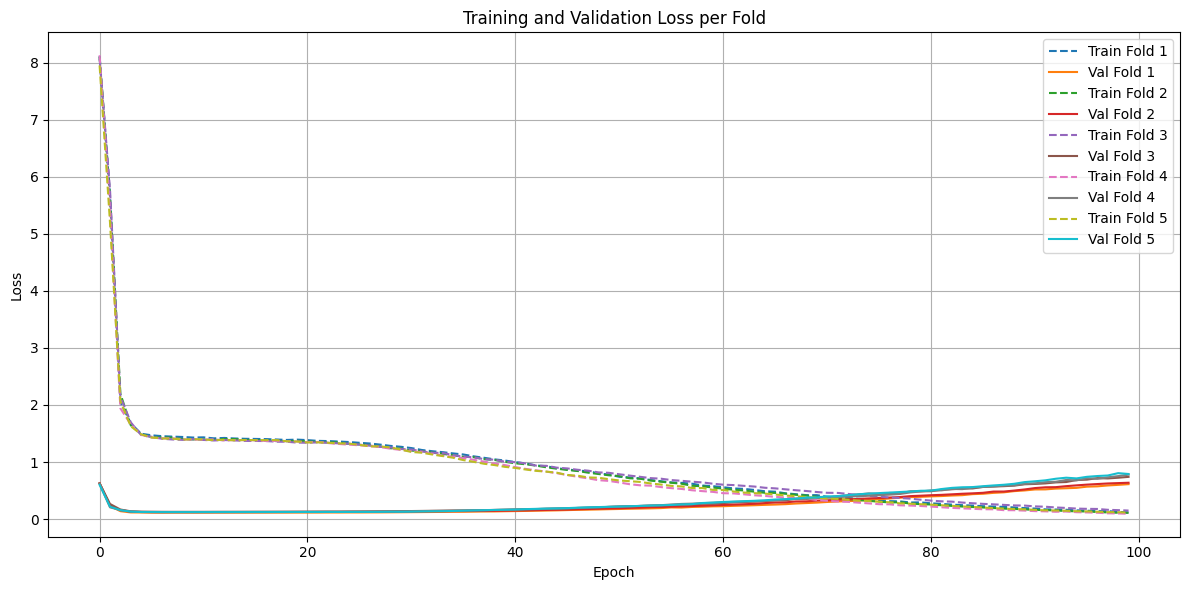

In [47]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

num_epochs = 100
batch_size = 64
k_folds = 5

criterion = nn.BCELoss()
kfold = KFold(n_splits=k_folds, shuffle=True)

# To store loss history for all folds
all_train_losses = []
all_val_losses = []

best_val_loss = float('inf')
best_model_state = None

for fold, (train_ids, val_ids) in enumerate(kfold.split(X_test_tensor)):
    print(f'Fold {fold+1}')

    # Split data
    train_X, train_y = X_test_tensor[train_ids], y_test_tensor[train_ids]
    val_X, val_y = X_test_tensor[val_ids], y_test_tensor[val_ids]

    model = SimpleMLP(input_dim=X.shape[1], output_dim=y_test_tensor.shape[1])
    optimizer = torch.optim.Adam(model.parameters())

    # Store losses per epoch for this fold
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        total_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = train_X[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_X)
            val_loss = criterion(val_outputs, val_y).item()

        train_losses.append(total_loss)
        val_losses.append(val_loss)

        print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Save fold losses
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

# Plotting after training
plt.figure(figsize=(12, 6))
for fold in range(k_folds):
    plt.plot(all_train_losses[fold], label=f'Train Fold {fold+1}', linestyle='--')
    plt.plot(all_val_losses[fold], label=f'Val Fold {fold+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Fold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Load best model
best_model = SimpleMLP(input_dim=X.shape[1], output_dim=y_test_tensor.shape[1])
best_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [49]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    test_loss = criterion(outputs, y_test_tensor)
    print(f"Test Loss: {test_loss.item()}")

    # Get top 6 predictions for each sample
    _, top6_indices = torch.topk(outputs, k=6, dim=1)

    # Total number of samples
    total_samples = y_test_tensor.shape[0]
    all_slots_correct_samples = 0
    single_slot_correct_samples = 0

    for i in range(total_samples):
        # Indices of true labels (where y == 1)
        true_indices = (y_test_tensor[i] == 1).nonzero(as_tuple=True)[0]

        # Skip if there are no true labels (optional: depends on your definition of accuracy)
        if true_indices.numel() == 0:
            continue

        # Indices predicted as top-6
        predicted_top6 = top6_indices[i]

        single_slot_correct = 0
        # Check if all true labels are in the top-6
        if set(true_indices.tolist()).issubset(set(predicted_top6.tolist())):
            all_slots_correct_samples += 1
            single_slot_correct_samples += 1
        else:
            for idx in true_indices.tolist():
                if idx in set(predicted_top6.tolist()):
                    single_slot_correct += 1
            single_slot_correct_samples += single_slot_correct / len(true_indices.tolist())

    # Top-6 accuracy based only on rows that had at least one positive label
    all_slots_accuracy = all_slots_correct_samples / total_samples
    single_slot_accuracy = single_slot_correct_samples / total_samples
    print(f"All slots - accuracy: {all_slots_accuracy:.4f}")
    print(f"Single slot - accuracy: {single_slot_accuracy:.4f}")

Test Loss: 0.1650373488664627
All slots - accuracy: 0.7978
Single slot - accuracy: 0.8706


In [134]:
# X_custom = pd.DataFrame(columns=X.columns)
# X_custom = pd.concat([pd.DataFrame([[0] * len(X_custom.columns)] * 256, columns=X_custom.columns), X_custom], ignore_index=True)

X_test_reindex = X_test.reset_index(drop=True)

X_custom = X_test_reindex.iloc[:340, :]

# Agora, converter todas as colunas para float32
X_custom_tensor = torch.tensor(X_custom.values.astype(np.float32))

model.eval()
with torch.no_grad():
    outputs = model(X_custom_tensor)
    topk_values, topk_indices = torch.topk(outputs, k=6, dim=1)

all_recommendations = []
for i in range(topk_indices.shape[0]):
    predicted_idx = []
    for idx in topk_indices[i]:
        predicted_idx.append(idx)
    predicted_items = []
    for id, idx in item_id_to_idx.items():
        if idx in predicted_idx:
            predicted_items.append(id)
    all_recommendations.append(predicted_items)

Allies: Bard, Darius, Kaisa, Pantheon, Vladimir
Enemies: DrMundo, Gwen, Lissandra, Rakan, Smolder
Recommendations: Guardian Angel                , Navori Flickerblade           , Phantom Dancer                , Runaan's Hurricane            , The Collector                 , Yun Tal Wildarrows            
Original build : Berserker's Greaves           , Guinsoo's Rageblade           , Kraken Slayer                 
Recommended build


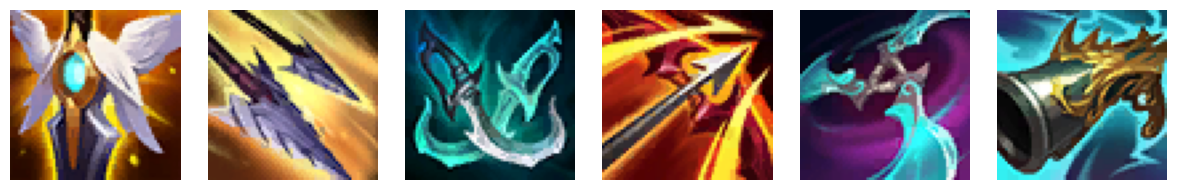

Original build


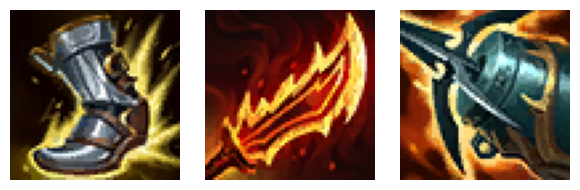

In [194]:
def show_build(item_ids):
    fig, axs = plt.subplots(1, len(item_ids), figsize=(2 * len(item_ids), 2))
    if len(item_ids) == 1:
        axs = [axs]  # ensure iterable
    for i, id in enumerate(item_ids):
        icon = get_item_icon(id)
        if icon:
            axs[i].imshow(icon)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

def compare_builds(
        df: pd.DataFrame,
        analysed_champion: str,
        all_recommendations: list,
        original_index,
        original_df,
        idx: int):
    reccomended_items = all_recommendations[idx]
    team100 = []
    team200 = []
    team = 100
    for item_col in df.columns:
        if df.loc[idx, item_col] == 1 and "team100" in item_col:
            team100.append(item_col.split("_")[1])
            if analysed_champion in item_col:
                team = 100
        if df.loc[idx, item_col] == 1 and "team200" in item_col:
            team200.append(item_col.split("_")[1])
            if analysed_champion in item_col:
                team = 200
    allies = team100 if team == 100 else team200
    enemies = team100 if team != 100 else team200
    print(f"Allies: {', '.join(champ for champ in allies)}")
    print(f"Enemies: {', '.join(champ for champ in enemies)}")
    print(f"Recommendations: {', '.join(
        sorted([f"{get_item_name(item):<30}" for item in reccomended_items])
    )}")

    original_build = []
    orig_idx = original_index[idx]
    champ_id = get_champion_id(analysed_champion)
    for i in range(10):
        id_col = f"{i}_championId"
        if original_df.loc[orig_idx, id_col] == champ_id:
            player_id = i
    for i in range(6):
        item_col = f"{player_id}_items_{i}"
        item_id = original_df.loc[orig_idx, item_col]
        if item_id.is_integer():
            original_build.append(item_id)
    print(f"Original build : {', '.join(
        sorted([f"{get_item_name(item):<30}" for item in original_build])
    )}")

    print("Recommended build")
    show_build(sorted(reccomended_items))

    print("Original build")
    show_build(sorted(original_build))

compare_builds(
    X_custom,
    "Kaisa",
    all_recommendations,
    original_index,
    df_same_lane,
    idx=10,
)

In [69]:
X_custom.head()

,team100_Aatrox,team100_Ahri,team100_Akali,team100_Akshan,team100_Alistar,team100_Ambessa,team100_Amumu,team100_Anivia,team100_Annie,team100_Aphelios,...,team200_Yone,team200_Yorick,team200_Yuumi,team200_Zac,team200_Zed,team200_Zeri,team200_Ziggs,team200_Zilean,team200_Zoe,team200_Zyra
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
